In [1]:
version = 'v20250521'

### Read in overlaid data

In [2]:
import pandas as pd
df = pd.read_parquet('./material/soc.snr_overlaid_v20250301.pq')
print(df.shape)

(122436, 468)


### Clean
- base on LUCAS, Spain, and Germany data
- drop data records without land cover info

In [3]:
keep_ref = ['ParcelasINES', 'LUCAS', 'thuenen.bze.lw', 'ParcelasCOS']
df = df.loc[df['ref'].isin(keep_ref)]
print(df.shape)
df = df.loc[df['lc_survey'].notna()]
print(df.shape)
print(df['ref'].unique().tolist())

(102651, 468)
(102650, 468)
['ParcelasINES', 'LUCAS', 'thuenen.bze.lw', 'ParcelasCOS']


### Remove some implausible point

In [4]:
## remove woodland and grassland points with soc==0
df = df[~((df['soc'] == 0) & (df['lc_survey'].isin(['woodland', 'grassland'])))]
print(df.shape)

(101998, 468)


### Harmonize soc measurements to standard depth 10cm

In [5]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
from skmap.misc import TimeTracker, ttprint

single_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) == 1)
single_records = single_depth_groups[single_depth_groups['hzn_dep'] <= 20].copy()
single_records['type'] = 'measured'
print("keep single-depth records with hzn_dep <= 20 cm, ", single_records.shape)

keep single-depth records with hzn_dep <= 20 cm,  (83792, 469)


In [6]:
multi_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) > 1)
multi_with_10 = multi_depth_groups[multi_depth_groups['hzn_dep'] == 10]
multi_records_10 = multi_with_10.copy()  
multi_records_10['type'] = 'measured'
print("Keep multi-depth records where hzn_dep = 10:", multi_records_10.shape)

Keep multi-depth records where hzn_dep = 10: (150, 469)


In [7]:
multi_depth_interpolate = multi_depth_groups.groupby(['lat', 'lon', 'time']).filter(lambda g: not (g['hzn_dep'] == 10).any())
print("multi-depth group needs interpolation count:", multi_depth_interpolate.shape)

itpl_records = []
for (lat, lon, time), group in multi_depth_interpolate.groupby(['lat', 'lon', 'time']):
    group = group.sort_values(by='hzn_dep').drop_duplicates(subset=['hzn_dep'])
    new_record = group.iloc[0].copy()  # keep all other columns
    for prop in ['soc','total.n','clay','ph.h2o','ph.cacl2']:
        try:
            # cs = CubicSpline(group['hzn_dep'], group[prop])
            pc = PchipInterpolator(group['hzn_dep'], group[prop])
            new_record[prop] = pc(10).item()  # interpolte
        except Exception as e:
            new_record[prop] = np.nan
            # print(f"Interpolation error at ({group['lat'].iloc[0]}, {group['lon'].iloc[0]}, {group['time'].iloc[0]}): {e}")
    new_record['hzn_dep'] = 10  # same as standard LUCAS depth
    itpl_records.append(new_record)
    
interpolated_records = pd.DataFrame(itpl_records)
interpolated_records['type'] = 'interpolated'
print("Interpolating hzn_dep==10cm for multi-depth groups,", interpolated_records.shape)

multi-depth group needs interpolation count: (17917, 468)
Interpolating hzn_dep==10cm for multi-depth groups, (3744, 469)


In [8]:
dff = pd.concat([single_records, multi_records_10, interpolated_records], ignore_index=True)
print("topsoil harmonized, ", dff.shape)

topsoil harmonized,  (87686, 469)


In [9]:
dff = dff.loc[dff['soc']>=0]
print(dff.shape)

(87684, 469)


### Visualize some examples

In [10]:
num_examples = 3
selected_groups = interpolated_records.sample(num_examples, random_state=42)[['lat', 'lon', 'time']]  # Select 3 unique groups
selected_examples = multi_depth_groups.merge(selected_groups, on=['lat', 'lon', 'time'])

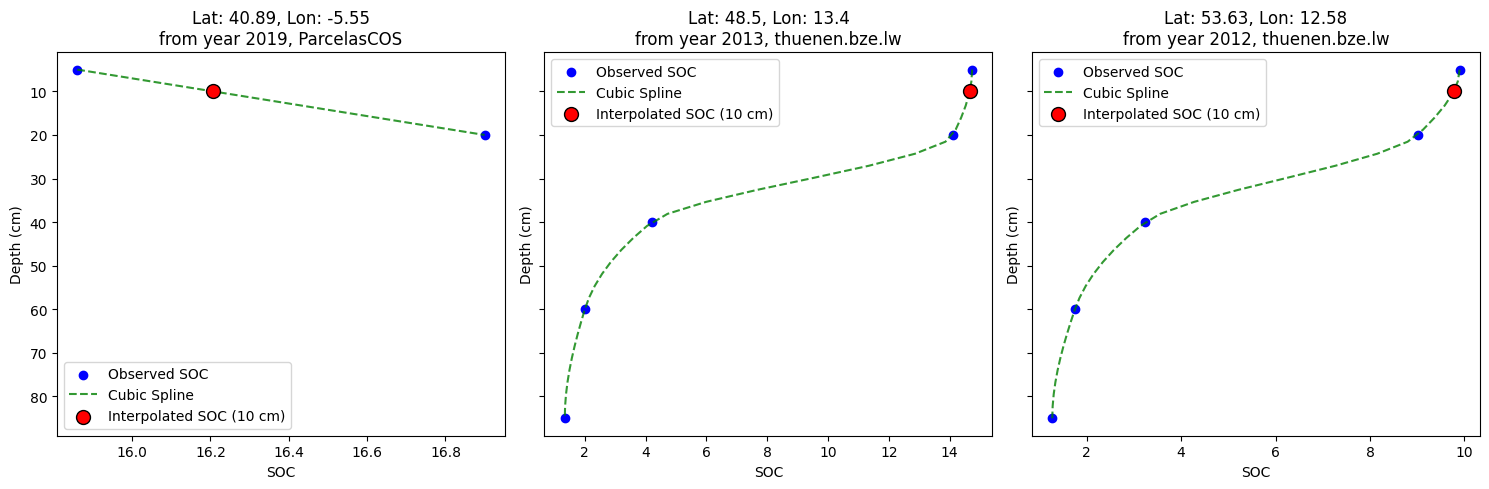

In [11]:
import matplotlib.pyplot as plt
import random
fig, axes = plt.subplots(1, num_examples, figsize=(15, 5), sharey=True)

for ax, ((lat, lon, time, ref), group) in zip(axes, selected_examples.groupby(['lat', 'lon','time','ref'])):
    group = group.sort_values(by='hzn_dep').drop_duplicates(subset=['hzn_dep'])

    pc = PchipInterpolator(group['hzn_dep'], group['soc'])
    depths = np.linspace(min(group['hzn_dep']), max(group['hzn_dep']), 30)
    soc_spline = pc(depths)
    interpolated_soc = pc(10)  

    ax.scatter(group['soc'], group['hzn_dep'], label="Observed SOC", color='blue', zorder=2)
    
    ax.plot(soc_spline, depths, label="Cubic Spline", linestyle='--', color='green', alpha=0.8)

    ax.scatter(interpolated_soc, 10, color='red', s=100, edgecolor='black', label="Interpolated SOC (10 cm)", zorder=3)

    ax.invert_yaxis()  # Depth increases downwards
    ax.set_ylabel("Depth (cm)")  
    ax.set_xlabel("SOC")  
    ax.set_title(f"Lat: {round(lat,2)}, Lon: {round(lon,2)}\nfrom year {time}, {ref}")
    ax.legend()

plt.tight_layout()
plt.show()


### Remove irrelevant columns

In [12]:
dff.columns[0:65]

Index(['time', 'lat', 'lon', 'id', 'clay', 'clay_unit', 'clay_method',
       'bulk.density.tot_unit', 'bulk.density.tot_method', 'bulk.density.tot',
       'coarse.mass_unit', 'coarse.mass_method', 'coarse.mass', 'lc_survey',
       'ref', 'nuts0', 'ph.h2o', 'bulk.density.fe', 'total.n', 'extractable.p',
       'WEB_ID_SQUARE (ID)', 'WEB_ID_PLOT', 'PLOT_TYPE',
       'bulk.density.fe_method', 'bulk.density.fe_unit', 'total.n_unit',
       'total.n_method', 'extractable.p_method', 'extractable.p_unit',
       'ph.h2o_method', 'ph.cacl2_method', 'ph.cacl2', 'extractable.k',
       'extractable.k_method', 'extractable.k_unit', 'cec', 'cec_unit',
       'cec_method', 'sand', 'silt', 'silt_method', 'silt_unit', 'sand_method',
       'sand_unit', 'total.c', 'c/n', 'total.c_method', 'total.c_unit',
       'carbonates', 'ec', 'carbonates_method', 'ec_method', 'ph.h2o_unit',
       'carbonates_unit', 'ec_unit', 'coarse.vol', 'coarse.vol_unit',
       'coarse.vol_method', 'ph.cacl2_unit', 'hzn_

In [13]:
drop_col = ['clay_unit', 'clay_method', 'bulk.density.tot_unit', 'bulk.density.tot_method', 'bulk.density.tot',
       'coarse.mass_unit', 'coarse.mass_method', 'coarse.mass', 'bulk.density.fe', 'extractable.p',
       'WEB_ID_SQUARE (ID)', 'WEB_ID_PLOT', 'PLOT_TYPE',
       'bulk.density.fe_method', 'bulk.density.fe_unit', 'total.n_unit',
       'total.n_method', 'extractable.p_method', 'extractable.p_unit',
       'ph.h2o_method', 'ph.cacl2_method', 'extractable.k',
       'extractable.k_method', 'extractable.k_unit', 'cec', 'cec_unit',
       'cec_method', 'sand', 'silt', 'silt_method', 'silt_unit', 'sand_method',
       'sand_unit', 'total.c', 'c/n', 'total.c_method', 'total.c_unit',
       'carbonates', 'ec', 'carbonates_method', 'ec_method', 'ph.h2o_unit',
       'carbonates_unit', 'ec_unit', 'coarse.vol', 'coarse.vol_unit',
       'coarse.vol_method', 'ph.cacl2_unit', 'ocd', 'ocd_method',
       'soc_qa']

dff = dff.drop(columns=drop_col)
print(dff.shape)

(87684, 418)


### organize covariate features

In [14]:
dff.columns[13::]

Index(['cropland.extent_glad.interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240604',
       'pft.trees.nd_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616',
       'ndvi_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127',
       'evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0901_YYYY1031_eu_epsg.3035_v20231127',
       'pft.grass.nat_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616',
       'pft.trees.bd_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616',
       'pft.bare_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616',
       'clm_lst_mod11a2.nighttime_p05_1km_s0..0cm_YYYY_v1.2',
       'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127',
       'evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0301_YYYY0430_eu_epsg.3035_v20231127',
       ...
       'CHELSA_gsp_1981-2010_V.2.1',
       'lithology.93.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.303

In [15]:
# for features with too many (>2%) nans
fix_col = []
covs = dff.columns[13::].tolist() # starting from 13 to -1, all covs
for icov in covs:
    inum = dff[icov].isna().sum()
    irto = round(inum/len(dff),3)
    
    if irto>0.02:
        print(icov, irto, dff[icov].min(), dff[icov].max())
        fix_col.append(icov)

cropland.extent_glad.interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240604 0.628 25.0 100.0
b3_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 104.0 6050.0
CHELSA_swe_1981-2010_V.2.1 0.666 35.0 12217.0
b12_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 43.0 6815.0
b6_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 51.0 7486.0
b4_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 119.0 6890.0
b2_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 57.0 5343.0
b8_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 45.0 7494.0
b11_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 65.0 8015.0
b7_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 54.0 7562.0
b5_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 157.0 7170.0
b8a_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.601 39.0 7857.0


In [16]:
fl = 'cropland.extent_glad.interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240604'
dff.loc[dff[fl].isna(),fl] = 0
dff.loc[dff[fl]>0,fl] = 100
fix_col.remove(fl)

fl = 'CHELSA_swe_1981-2010_V.2.1'
dff = dff.drop(columns=[fl])
fix_col.remove(fl)
covs.remove(fl)

for fl in fix_col:
    dff.loc[dff[fl].isna(),fl] = 0


In [17]:
print(dff.shape)
# for features with less than 2% nans
fix_col = []

for icov in covs:
    inum = dff[icov].isna().sum()
    irto = round(inum / len(dff), 3)
    
    if inum > 0:
        print(icov, irto, inum)
        fix_col.append(icov) 

# fill in nan with mean values
dff[fix_col] = dff[fix_col].fillna(dff[fix_col].mean())

(87684, 417)
ndvi_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.0 20
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0901_YYYY1031_eu_epsg.3035_v20231127 0.0 20
clm_lst_mod11a2.nighttime_p05_1km_s0..0cm_YYYY_v1.2 0.001 94
ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.0 20
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0301_YYYY0430_eu_epsg.3035_v20231127 0.0 20
wv_mcd19a2v061.seasconv.m.yearly_p25_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619 0.0 1
blue_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.0 20
swir1_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.0 20
wv_mcd19a2v061.seasconv.m.yearly_p50_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619 0.0 1
nos_glad.landsat.ard2.seasconv_m_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.0 20
bare.soil_mcd43a4.fc_m_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616 0.002 151
photosy

In [18]:
# double check the nan
for icov in covs:
    inum = dff[icov].isna().sum()
    irto = round(inum / len(dff), 3)
    
    if inum > 0:
        print(icov, irto, inum)
        fix_col.append(icov) 

In [21]:
dummies = pd.get_dummies(dff['soilsuite_mask'], prefix='soilsuite')
dummies = dummies.rename(columns={'soilsuite_1.0':'soilsuite_bare', 'soilsuite_2.0':'soilsuite_veg','soilsuite_3.0':'soilsuite_other'})
dff = pd.concat([dff, dummies], axis=1)
dff = dff.drop(columns=['soilsuite_mask','soilsuite_1.6074553728103638'])
print(dff.shape)

(87684, 419)


## check duplicates

In [22]:
dff.loc[dff.duplicated()]

Empty DataFrame
Columns: [time, lat, lon, id, clay, lc_survey, ref, nuts0, ph.h2o, total.n, ph.cacl2, hzn_dep, soc, cropland.extent_glad.interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240604, pft.trees.nd_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, ndvi_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0901_YYYY1031_eu_epsg.3035_v20231127, pft.grass.nat_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, pft.trees.bd_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, pft.bare_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, clm_lst_mod11a2.nighttime_p05_1km_s0..0cm_YYYY_v1.2, ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0301_YYYY0430_eu_epsg.3035_v20231127, wv_mcd19a2v061.seasconv.m.yearly_p25_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619, blue_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, swir1_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, wv_mcd19a2v061.seasconv.m.yearly_p50_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619, pft.trees.be_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, pft.trees.ne_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, nos_glad.landsat.ard2.seasconv_m_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, bare.soil_mcd43a4.fc_m_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616, photosynthetic.veg_mcd43a4.fc_std_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616, nir_glad.landsat.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY1101_YYYY1231_eu_epsg.3035_v20231127, ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218, photosynthetic.veg_mcd43a4.fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616, non.photosynthetic.veg_mcd43a4.fc_std_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616, ndti_glad.landast.ard2.seasconv.m.yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218, evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0701_YYYY0831_eu_epsg.3035_v20231127, green_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, clm_lst_mod11a2.daytime_p05_1km_s0..0cm_YYYY_v1.2, non.photosynthetic.veg_mcd43a4.fc_std_gf_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20250116, clm_lst_mod11a2.nighttime_p95_1km_s0..0cm_YYYY_v1.2, red_glad.landsat.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, pft.built_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, non.photosynthetic.veg_mcd43a4.fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616, ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, green_glad.landsat.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, thermal_glad.landsat.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, pft.water.inland_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, red_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, ndti.min_glad.landsat.ard2.seasconv.bimonthly.min_m_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218, pft.shrubs.ne_esa.cci.lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg.4326_v20230616, clm_lst_mod11a2.nighttime_p50_1km_s0..0cm_YYYY_v1.2, swir2_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, thermal_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127, wv_mcd19a2v061.seasconv.sd.yearly_p75_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619, evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0501_YYYY0630_eu_epsg.3035_v20231127, ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101

## save file

In [23]:
dff.loc[dff['lc_survey']=='bare land & lichens/moss','lc_survey'] = 'bareland'
dff.loc[dff['lc_survey']=='water areas & wetland','lc_survey'] = 'wetland'

dff['lc_survey'].value_counts()

lc_survey
cropland           36941
woodland           25882
grassland          20590
shrubland           2028
bareland            1593
others               250
wetland              216
artificial land      184
Name: count, dtype: int64

In [24]:
dff.to_parquet(f'./material/soc.topsoil_organized_{version}.pq')

## assign tile id

In [25]:
import geopandas as gpd
eu_tile = gpd.read_file('/home/xuemeng/work_xuemeng/soc/data/000_tiles.correct_epsg.3035.gpkg')

In [26]:
gdf = gpd.GeoDataFrame(dff, geometry=gpd.points_from_xy(dff.lon, dff.lat))
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(eu_tile.crs)

joined_gdf = gpd.sjoin(gdf, eu_tile, how="left", op='within')
joined_gdf = joined_gdf.drop(columns=['geometry','index_right'])
joined_gdf = joined_gdf.rename(columns={'id_right':'tile_id','id_left':'id'})
print(joined_gdf.shape)
print(dff.shape)
joined_gdf.to_parquet(f'./material/soc.topsoil_organized_{version}.pq')


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


(87684, 420)
(87684, 419)


## check in QGIS on the location

In [27]:
import pandas as pd
tt = pd.read_parquet(f'./material/soc.topsoil_organized_{version}.pq')

In [28]:
tt = tt[tt.columns[0:13]]

In [29]:
tt.shape

(87684, 13)

In [30]:
tt.to_csv('./material/pnt_location_check.csv')

In [31]:
lt = tt.loc[tt['ref']=='LUCAS']

In [32]:
lt.to_csv('./material/pnt.lucas_location_check.csv')

In [33]:
dff.columns

Index(['time', 'lat', 'lon', 'id', 'clay', 'lc_survey', 'ref', 'nuts0',
       'ph.h2o', 'total.n',
       ...
       'b8a_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307',
       'min.curv.bareearth_ensemble_m_30m_s_20000101_20221231_eu_epsg.3035_v20240424',
       'CHELSA_bio1_1981-2010_V.2.1',
       'lithology.105.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530',
       'fapar_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231218',
       'ls.factor.bareearth_ensemble_m_480m_s_20000101_20221231_eu_epsg.3035_v20240501',
       'type', 'soilsuite_bare', 'soilsuite_veg', 'soilsuite_other'],
      dtype='object', length=419)